title: Analyse impact of bad video verification experience on subsequent user journey  
author: Claudia Dai   
date: 2020-10-14   
region: EU   
tags: acquire, kyc, call quality, user journey, video verification, logistic regression
summary: There is an internal KYC QA team that reviews video KYC verification calls and rates them for quality, on several dimensions. This work aims to analyze whether bad KYC call quality has an effect on the subsequent user journey (card activation and first-time MAU). We are observing the effect of KYC call quality on 1271 users who initiated KYC in the time period from 2020-05-05 until 2020-08-05. We conducted exploratory data analysis, statistical tests (t-test, chi-square test), and logistic regression to analyze the variables’ relationship and provide a quantified value for the strength of association.

[DATA-8971]
# Analyse impact of bad video verification experience on subsequent user journey

There is an internal KYC QA team that reviews video KYC verification calls and rates them for quality, on several dimensions. The hypothesis is that users who have a bad experience with video KYC will be much less likely to become loyal N26 customers.

**The Google Slides presentation of this analysis can be found [here](https://docs.google.com/presentation/d/1A24u84I5nJSIVXIMq-LQIBB4raSlqvowSgrFKm01XWY/edit).**

# KYC QA data

The QA team collect their findings in [this spreadsheet](https://docs.google.com/spreadsheets/d/1snu_SAm5Cj0rYTQHPsML_wLTRE2eu77Lyi_Z9Y1-2_0/edit?usp=sharing). Jasmin Altmann is the QA team lead, and can provide additional context on the data or the video KYC process.

**Data sampling**: 2% of all calls received are sampled at random.

**Error classification**:
- **minor** = watch, for internal reporting, no exposure to user
- **serious** = error, for internal reporting, no exposure to user
- **reset** = for BAFIN/GDPR, the call has to be reset means that the user has to do it again.

**Duration of call**: 7-8 minutes is acceptable, if it's longer then something didn't go right usually on the user side. If it's a longer call, agent might get irritated which has an impact on user experience of KYC call.

**Audio and video quality**: is measured on agent's side, so we don't have any direct insights whether the quality was good on the user side. That could be infered from the duration of the call. If quality on agent side is not good, agent might get irritated too.

**Error scoring**: was done by one of the working students. Right now it's not working, but Jasmin can get it working if it proves to be of value for analysis.

**Sheet tabs**: Until August 2020, two batches are saved in two sheets for each month. The batches go from 5th of every month until 20th, and from 20th until 5th. As of September 2020, there will be weekly batches that all are entered into one single sheet for the month.

# Approach

We want to analyze whether our (KYC call quality) features can explain outcome variables related to the subsequent user journey.

Features (on sampled call/user level):
- Call duration (`call_duration`): efficient, OK, long
- Audio and video quality (`audio_and_video_quality`): acceptable, not acceptable
- Agent competence (`competence`): good, improvable, risky
- Agent feedback (`feedback`): good, improvable, risky
- Agent language (`language`): good, improvable, risky
- Agent guidance (`guidance`): good, improvable, risky
- KYC reset (`kyc_reset`): True, False → a KYC reset means the user has to redo KYC call
- SU-to-KYC time (`su_to_kyc_days`): number for days between SU and the KYCi call (added feature that was not part of the KYC QA, based on the hypothesis: if users take longer to even get to KYC after they signed up, there may be a lack of urgency and/or interest)

Are these features predictive of/can these features explain the following outcome variables:
- completed card activation within 30 days after the KYC call? (`is_card_f30d`)
- first-time MAU within 30 days after the KYC call, a.k.a. completed first top-up? (`is_ftmau_f30d`)

We used exploratory data analysis to observe any significant **differences between the outcome variable groups** (e.g., has activated card vs. has not activated card).

We used statistical tests (t-test, chi-square test) to check **whether the differences were significant**.

When applicable, we ran a logistic regression in order to analyze the relationship between the variables and determine whether this relationship can be described by means of a logistic regression. In these cases, logistic regression can **provide a quantified value for the strength of the association** of the variables.

In [1]:
%%capture
"""
!pip install imblearn
"""

from functions import *

In [2]:
# KYC data
df_kyc = pd.read_csv("kyc_qa.csv", index_col=0)
cols_as_datetime(df_kyc, ["call_initiated", "call_completed"])
date_start = df_kyc.call_initiated.min().date()
date_end = df_kyc.call_initiated.max().date() - timedelta(days=30)

# user data
filename = generate_filename("data/", "DATA-8971", "cleaned", date_start, date_end)
data = pd.read_csv(filename)
data = data.set_index("user_id")

# split outcome and independent variables
preds = list(data.filter(regex=("is_.*")).columns)
feats = list(np.setdiff1d(data.columns, preds))

# control which dummy variables are dropped - either the best or the worst rating
drop_dummies_neg = [
    "audio_video_quality_not acceptable",
    "call_duration_long",
    "competence_risky",
    "feedback_risky",
    "guidance_risky",
    "kyc_reset_True",
    "language_risky",
]
drop_dummies_pos = [
    "audio_video_quality_acceptable",
    "call_duration_efficient",
    "competence_good",
    "feedback_good",
    "guidance_good",
    "kyc_reset_False",
    "language_good",
]

---

# How does our data look like?

In [4]:
print(f"Rows: \t\t{data.shape[0]}\nColumns: \t{data.shape[1]}")

Rows: 		1271
Columns: 	13


In [5]:
print("Description of outcome variables:")
data[preds].describe().T

Description of outcome variables:


,count,mean,std,min,25%,50%,75%,max
is_premium,1271.000,0.054,0.225,0.000,0.000,0.000,0.000,1.000
is_card_f30d,1271.000,0.776,0.417,0.000,1.000,1.000,1.000,1.000
is_ftmau_f30d,1271.000,0.601,0.490,0.000,0.000,1.000,1.000,1.000
is_closed,1271.000,0.054,0.225,0.000,0.000,0.000,0.000,1.000


In [6]:
print("Description of feature variables:")
data[feats].describe(include="all").T

Description of feature variables:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
audio_video_quality,1236,2,acceptable,1173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
call_duration,1235,3,efficient,728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
competence,1236,3,good,1038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
feedback,1236,3,good,1189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guidance,1235,3,good,1156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kyc_reset,1271,2,False,1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
language,1236,3,good,1208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
su_to_kyc_days,1271.000,NaN,NaN,NaN,88.278,244.265,0.000,0.000,1.000,31.000,1842.000
su_to_kyc_days_log,1271.000,NaN,NaN,NaN,1.781,2.263,0.000,0.000,0.693,3.466,7.519


---

In [7]:
print(
    f"We are observing effect of KYC call quality on users who initiated KYC in the time period from {date_start} until {date_end}."
)

We are observing effect of KYC call quality on users who initiated KYC in the time period from 2020-05-05 until 2020-08-05.


---

# Do risky KYC calls have a (negative) impact on whether or not a user activates their card within 30 days after that call (`is_card_f30d`)?

In [8]:
pred = "is_card_f30d"

print(f"We inspect the following features on their impact on {pred}:")
for feat in feats:
    print(f"- {feat}")

We inspect the following features on their impact on is_card_f30d:
- audio_video_quality
- call_duration
- competence
- feedback
- guidance
- kyc_reset
- language
- su_to_kyc_days
- su_to_kyc_days_log


## How many users activated their card within 30 days of the KYC call?

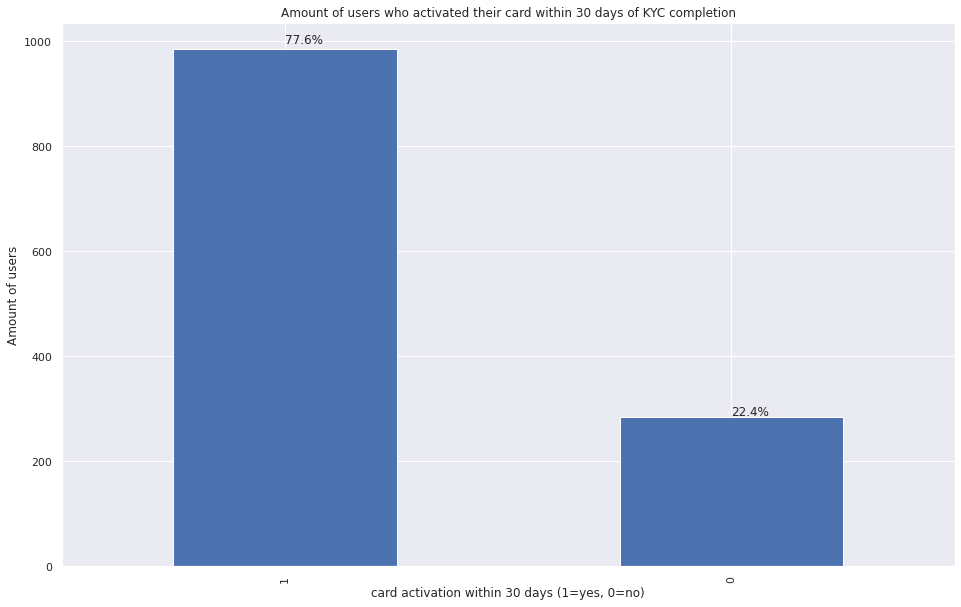

In [9]:
ax = data[pred].value_counts().plot(kind="bar")
plt.title("Amount of users who activated their card within 30 days of KYC completion")
plt.xlabel("card activation within 30 days (1=yes, 0=no)")
plt.ylabel("Amount of users")

total = len(data[pred])
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() * 1.01
    ax.annotate(percentage, (x, y))

plt.show()

Of the 1271 users whose KYC calls were sampled for quality assessment, 77.6% have activated their cards within 30 days after the call, while 22.4% have not.

## Can we observe a difference between individual feature values with regards to the outcome?

In [10]:
feats_str = get_str_cols(data)
feats_num = np.setdiff1d(get_num_cols(data), preds).tolist()

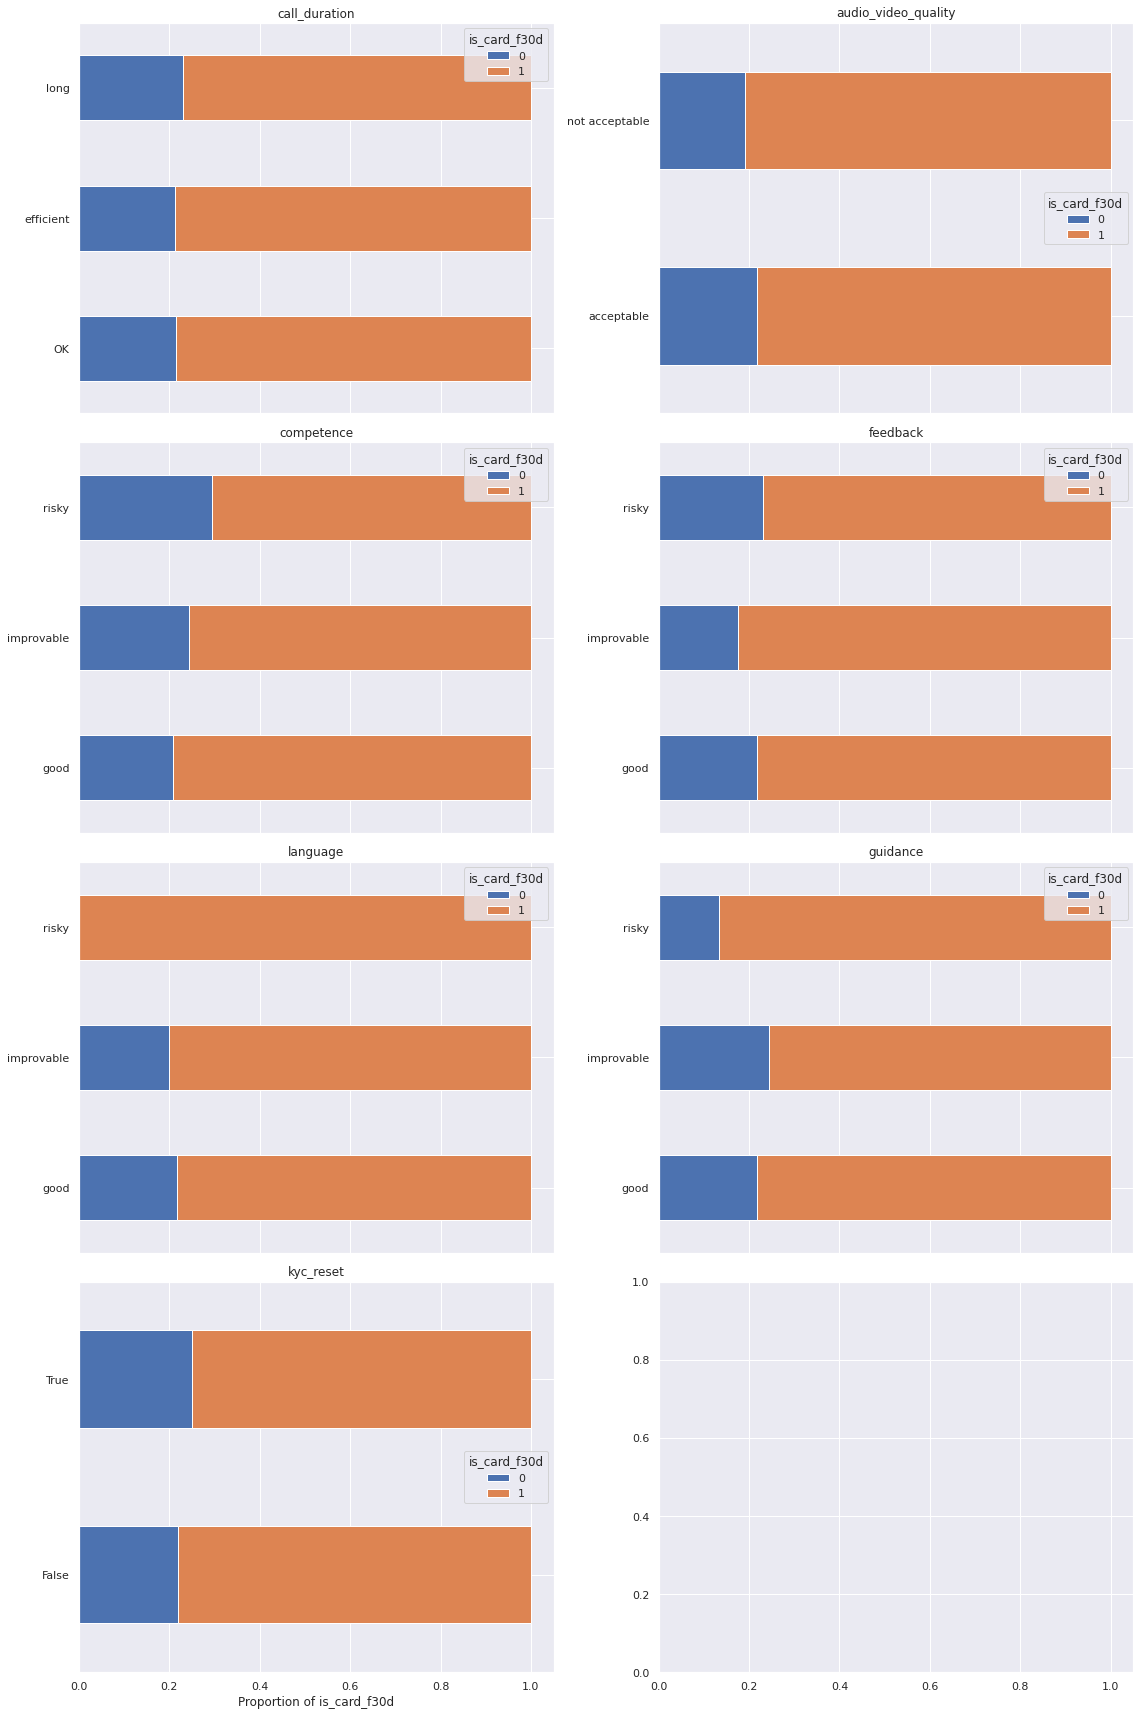

In [11]:
get_crosstab_plots(data, pred, feats_str)

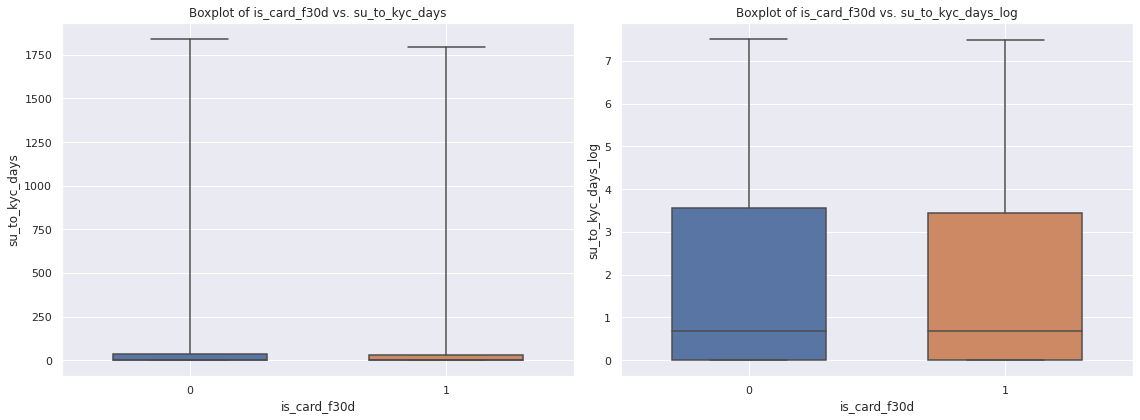

In [12]:
get_boxplots(data, pred, feats_num)

There could be a difference in (1) `competence` and (2) `kyc_reset` with regards to whether a user will activate their card within 30 days.

## `is_card_f30d` ∼ `kyc_reset` 

In [13]:
select_feats = "kyc_reset"

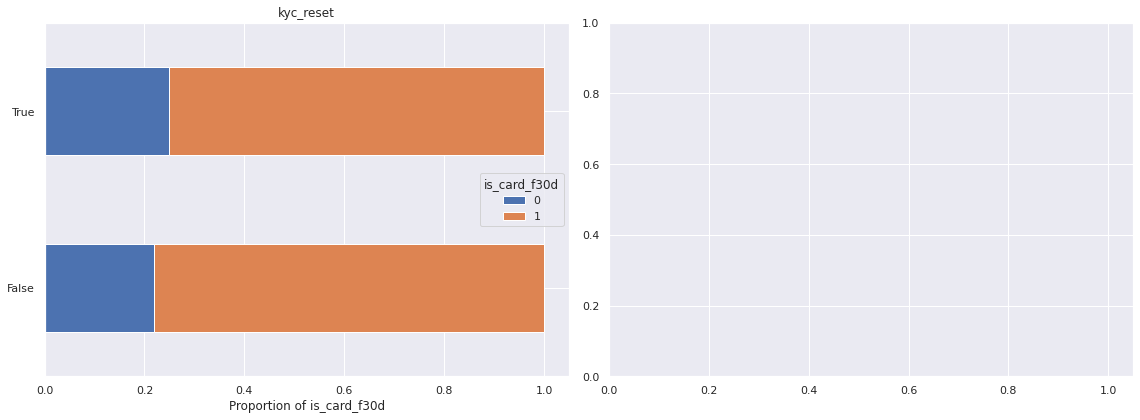

In [14]:
get_crosstab_plots(data, pred, [select_feats])

When the call was not reset, more users activated their cards within 30 days of the call than when the call was reset.

In [15]:
contingency_table = pd.crosstab(data.is_ftmau_f30d, data.kyc_reset)
contingency_table

kyc_reset,False,True
is_ftmau_f30d,,
0,434,73
1,649,115


In [16]:
chisquare, p_val, dof, exp_val, critical_value = chi_square_test(contingency_table)

chi=0.058026, critical value=6.634897

At 0.01 level of significance, we fail to reject the null hypotheses. 
    They are independent.

p-value=0.809644, significance=0.01

At 0.01 level of significance, we fail to reject the null hypotheses. 
    They are independent.


This difference, however, is **not significant**.

## `is_card_f30d` ∼ `competence`

In [17]:
select_feats = "competence"

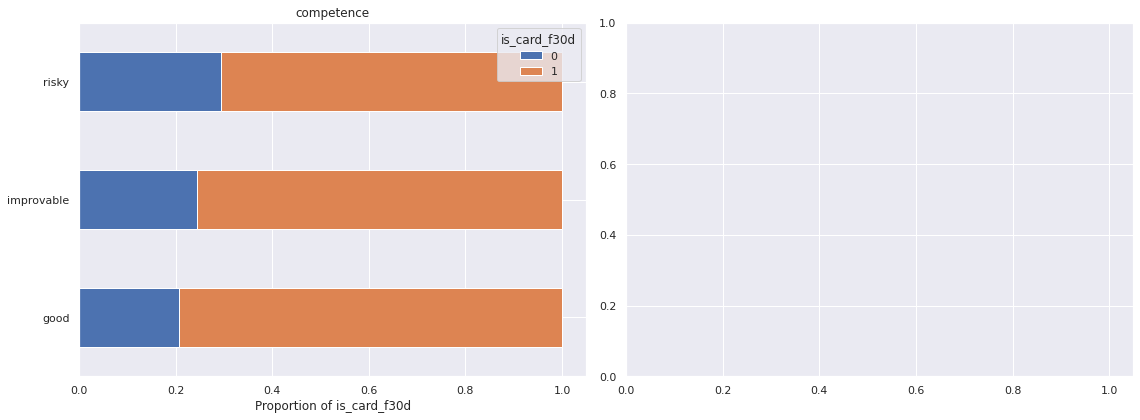

In [18]:
get_crosstab_plots(data, pred, [select_feats])

The better the agent’s competence, the more users activated their cards within 30 days of the call (good competence has the most, risky competence the least).

In [19]:
contingency_table = pd.crosstab(data.is_ftmau_f30d, data.competence)
contingency_table

competence,good,improvable,risky
is_ftmau_f30d,,,
0,402,56,29
1,636,67,46


In [20]:
chisquare, p_val, dof, exp_val, critical_value = chi_square_test(contingency_table)

chi=2.147809, critical value=9.210340

At 0.01 level of significance, we fail to reject the null hypotheses. 
    They are independent.

p-value=0.341672, significance=0.01

At 0.01 level of significance, we fail to reject the null hypotheses. 
    They are independent.


This difference, however, is **not significant**.

---

# Do risky KYC calls have an impact on whether or not a user becomes a first-time MAU within 30 days after that call (`is_ftmau_f30d`)?

In [21]:
pred = "is_ftmau_f30d"

print(f"We inspect the following features on their impact on {pred}:")
for feat in feats:
    print(f"- {feat}")

We inspect the following features on their impact on is_ftmau_f30d:
- audio_video_quality
- call_duration
- competence
- feedback
- guidance
- kyc_reset
- language
- su_to_kyc_days
- su_to_kyc_days_log


## How many users were first time MAU within 30 days of the KYC call?

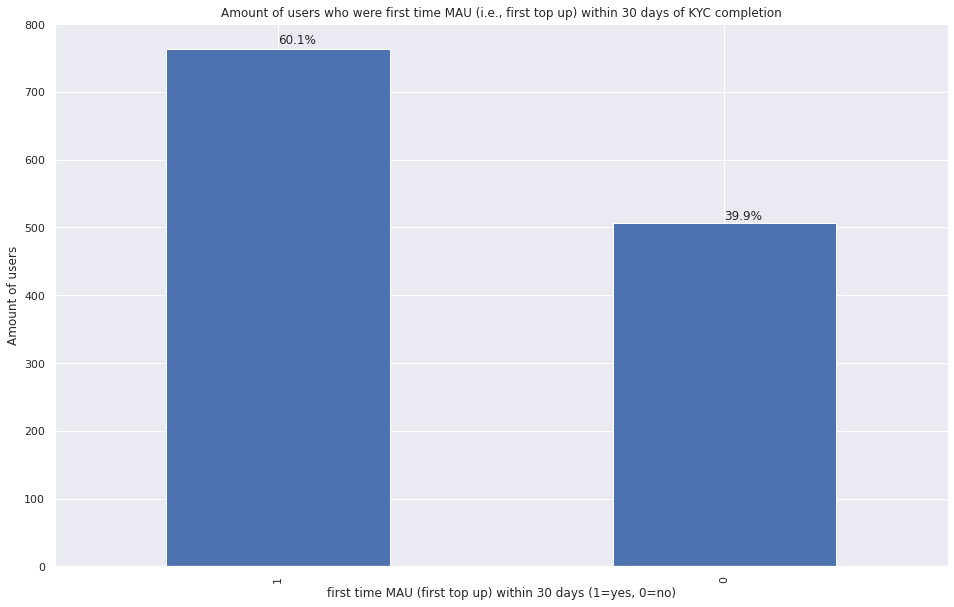

In [22]:
ax = data[pred].value_counts().plot(kind="bar")
plt.title(
    "Amount of users who were first time MAU (i.e., first top up) within 30 days of KYC completion"
)
plt.xlabel("first time MAU (first top up) within 30 days (1=yes, 0=no)")
plt.ylabel("Amount of users")

total = len(data[pred])
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() * 1.01
    ax.annotate(percentage, (x, y))

plt.show()

Of the 1271 users whose KYC calls were sampled for quality assessment, 60.1% became a first-time MAU (i.e., first top up completed) within 30 days after the call, while 39.9% have not.

## Can we observe a difference between individual feature values with regards to the outcome?

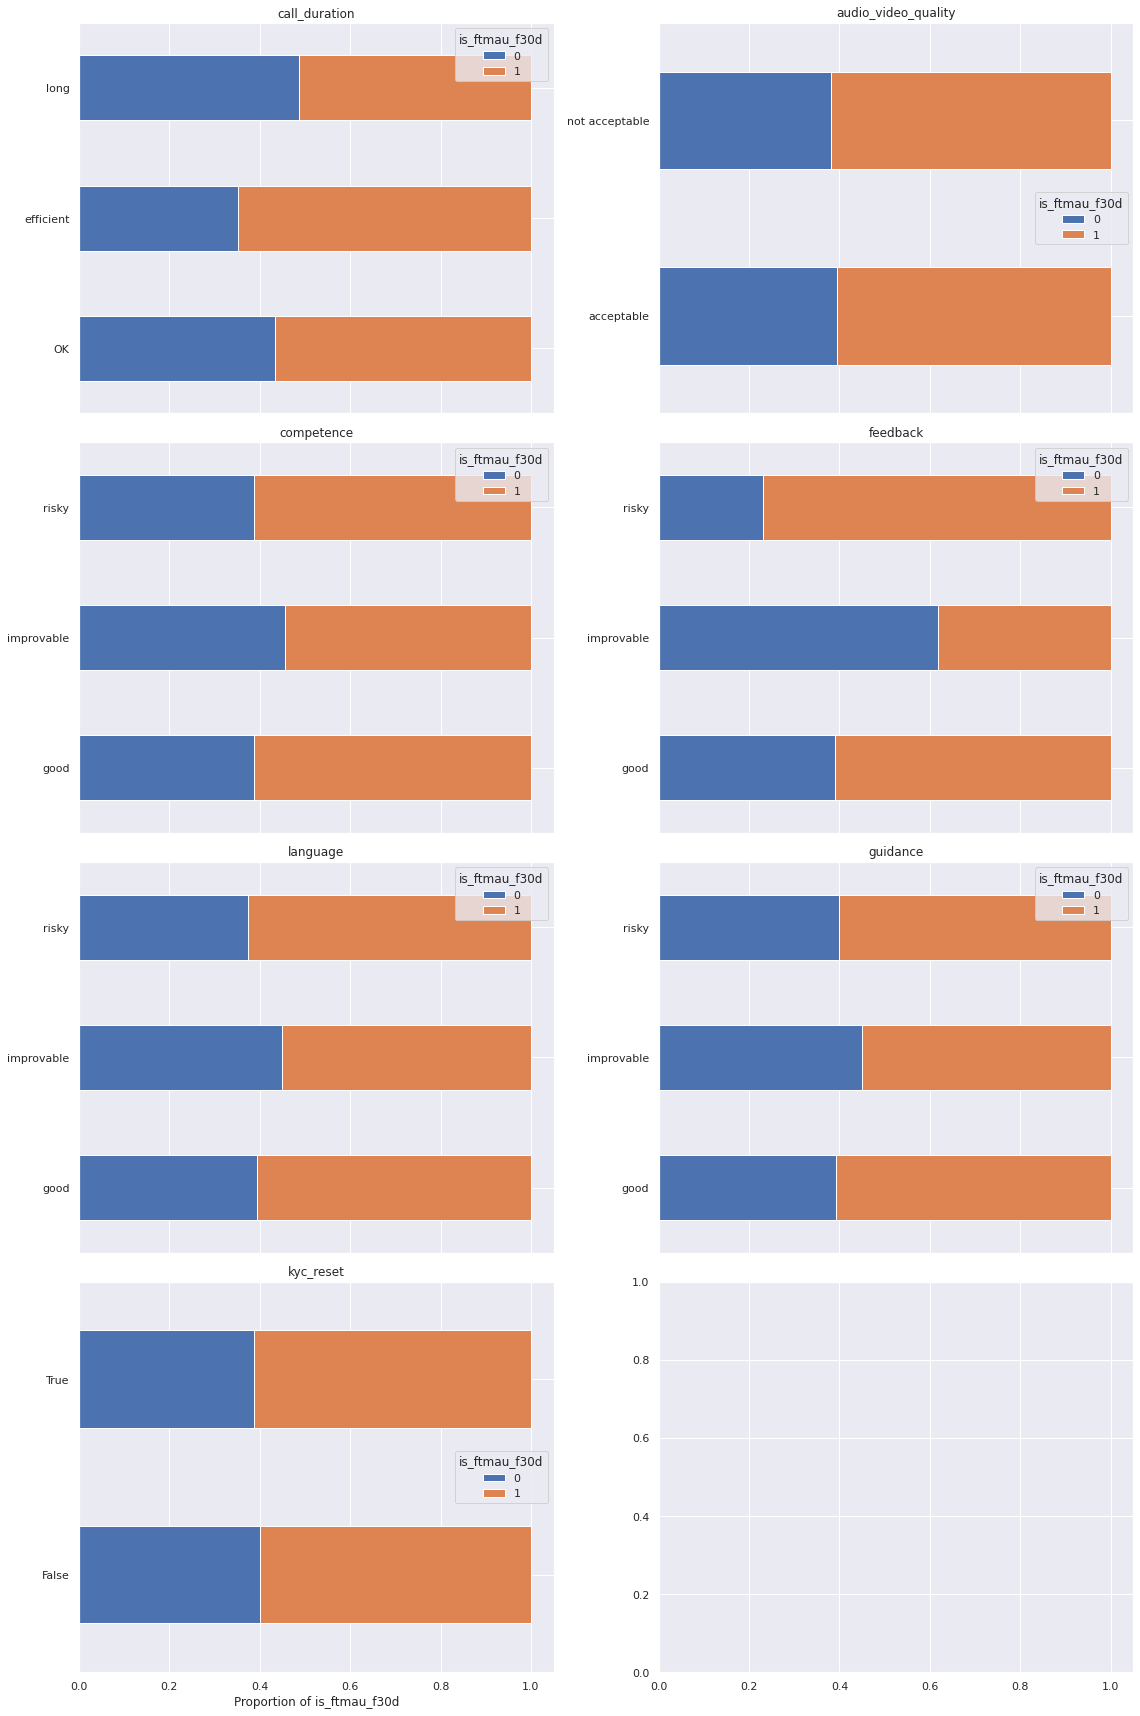

In [23]:
feats_str = get_str_cols(data)
feats_num = np.setdiff1d(get_num_cols(data), preds).tolist()

get_crosstab_plots(data, pred, feats_str)

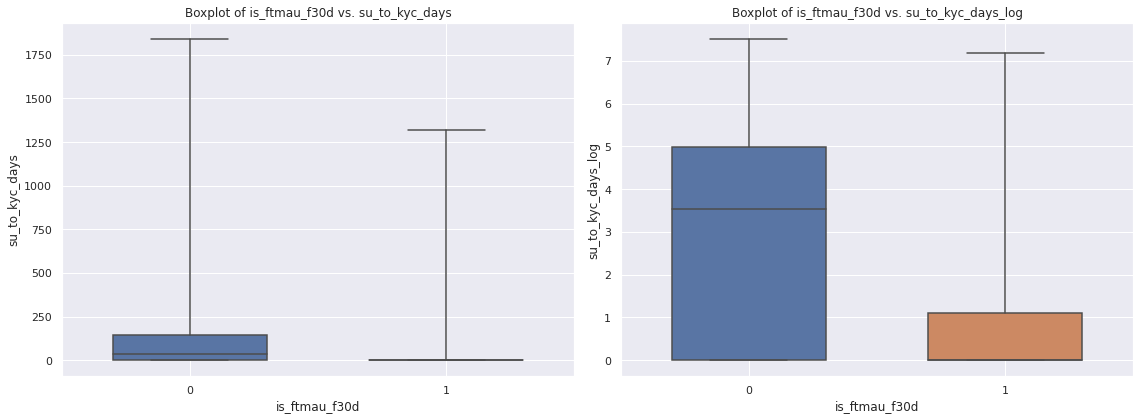

In [24]:
get_boxplots(data, pred, feats_num)

There could be a difference in (1) `call_duration` and (2) `su_to_kyc_days` with regards to whether a user will become first-time MAU within 30 days.

## `is_ftmau_f30d` ∼ `su_to_kyc_days` 

Since the data is quite skewed, we should take the natural log of the time it took that users did KYC after SU (in days), but we ended up not doing that due to the impact of AME interpretability. Caution that any model results may be not strong enough, as skewed data violates an assumption of logistic regression modelling.

In [25]:
select_feats = "su_to_kyc_days"

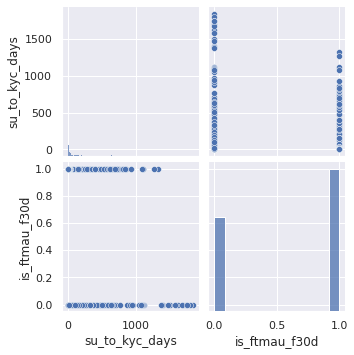

In [26]:
sns.pairplot(data[["su_to_kyc_days", pred]])
plt.show()

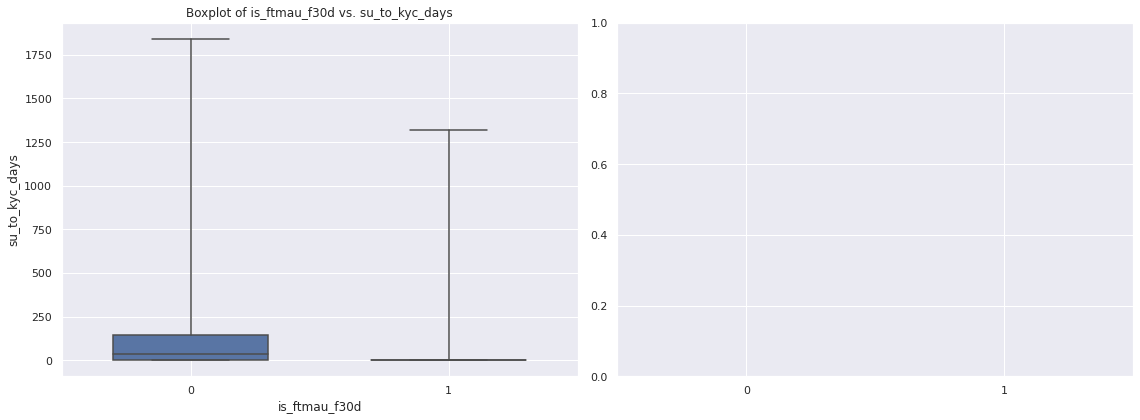

In [27]:
get_boxplots(data, pred, ["su_to_kyc_days"])

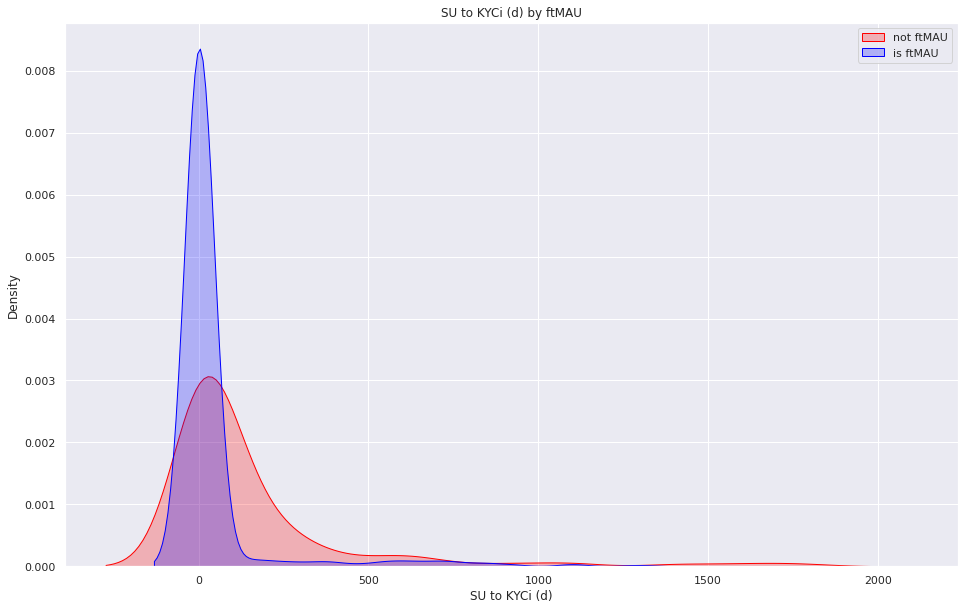

In [28]:
Mth = sns.kdeplot(data.su_to_kyc_days[(data[pred] == 0)], color="Red", shade=True)
Mth = sns.kdeplot(
    data.su_to_kyc_days[(data[pred] == 1)], ax=Mth, color="Blue", shade=True
)
Mth.legend(["not ftMAU", "is ftMAU"], loc="upper right")
Mth.set_ylabel("Density")
Mth.set_xlabel("SU to KYCi (d)")
Mth.set_title("SU to KYCi (d) by ftMAU")
plt.show()

The shorter the time that passes between SU and KYCi, the more users became a first-time MAU within 30 days after the call. But is that difference significant? There are overlaps between both distributions.

Null hypothesis: SU-to-KYC time in days of first-time MAUs and not first-time MAUs is the same or longer.

H<sub>0</sub>: `su_to_kyc_days(first-time MAU)` >= `su_to_kyc_days(not first-time MAU)`

Alternate hypothesis: SU-to-KYC time in days of first-time MAUs is shorter.

H<sub>1</sub>: `su_to_kyc_days(first-time MAU)` < `su_to_kyc_days(not first-time MAU)`

This is a left-tailed test.

In [29]:
a = data[data.is_ftmau_f30d == 1]["su_to_kyc_days"]
b = data[data.is_ftmau_f30d == 0]["su_to_kyc_days"]
t_stat, p_val = two_sample_ttest(a, b, tail="left")

t stat: 	-8.4242
p value: 	0.000000


This difference is **significant**.

In [30]:
result, odds_ratios, AME = run_logit(
    data, [select_feats], pred, drop_dummies_pos, significance=False
)

result.summary()

Running Logit with 1 feature(s).


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          is_ftmau_f30d   No. Observations:                 1271
Model:                          Logit   Df Residuals:                     1269
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:                 0.04242
Time:                        12:21:20   Log-Likelihood:                -818.56
converged:                       True   LL-Null:                       -854.83
Covariance Type:            nonrobust   LLR p-value:                 1.646e-17
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
su_to_kyc_days    -0.0024      0.000     -6.955      0.000      -0.003      -0.002
intercept          0.6055      0.063      9.600      0.000       0.482       0.729
==================================================================================
"""

Pseudo R-square is `0.0424` (0.2-0.4 is indication of a good model). Model is not very strong/reliable.

In [31]:
odds_ratios

,5%,95%,Odds Ratio
su_to_kyc_days,0.997,0.998,0.998
intercept,1.619,2.073,1.832


In [32]:
AME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:          is_ftmau_f30d
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
su_to_kyc_days    -0.0005   7.28e-05     -7.469      0.000      -0.001      -0.000
==================================================================================
"""

One unit increase in SU-to-KYC time (in days) decreases the probability of a user becoming first-time MAU within 30 days after the KYC call by 0.05%-points.

## `is_ftmau_f30d` ∼ `call_duration`

In [33]:
select_feats = "call_duration"

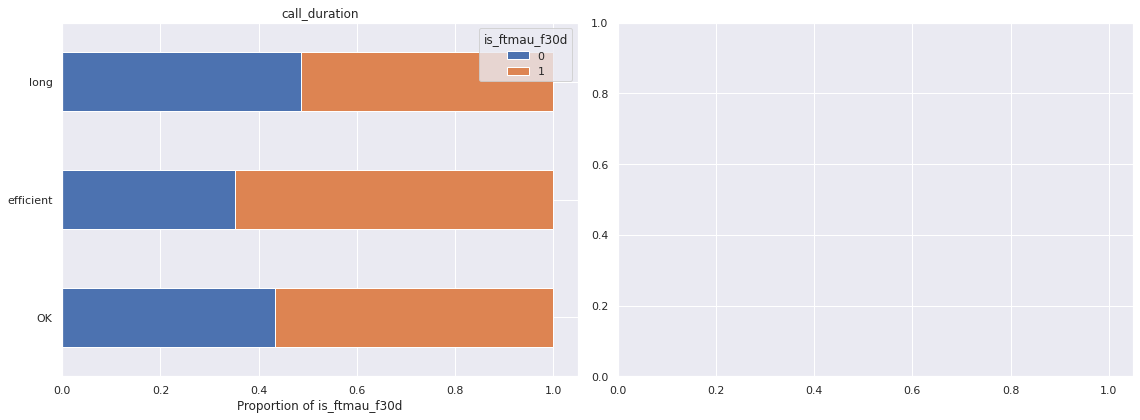

In [34]:
get_crosstab_plots(data, pred, [select_feats])

The shorter the call duration, the more users became a first-time MAU within 30 days after the call. Is that difference significant? To check if the difference between these groups is statistically significant, we can run a chi<sup>2</sup>-test for independence.

Null hypothesis: The two categorical variables (`call_duration` vs. `is_ftmau_f30d`) are independent.

Alternate hypothesis: The two categorical variables (`call_duration` vs. `is_ftmau_f30d`) are dependent (there is an association between the two variables).

Rejection region of chi-square is always on the right side of the distribution. We choose `alpha = 0.01` as a measure of how certain we want to be about our results.

In [35]:
contingency_table = pd.crosstab(data.is_ftmau_f30d, data.call_duration)
contingency_table

call_duration,OK,efficient,long
is_ftmau_f30d,,,
0,137,256,93
1,179,472,98


In [36]:
chisquare, p_val, dof, exp_val, critical_value = chi_square_test(contingency_table)

chi=14.449058, critical value=9.210340

At 0.01 level of significance, we reject the null hypotheses and accept H1. 
    They are not independent.

p-value=0.000728, significance=0.01

At 0.01 level of significance, we reject the null hypotheses and accept H1. 
    They are not independent.


This difference is **significant**.

In [37]:
# dropping positive dummies
result, odds_ratios, AME = run_logit(
    data, [select_feats], pred, drop_dummies_pos, significance=False
)
result.summary()

Running Logit with 1 feature(s).


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          is_ftmau_f30d   No. Observations:                 1271
Model:                          Logit   Df Residuals:                     1268
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:                0.006946
Time:                        12:21:21   Log-Likelihood:                -848.89
converged:                       True   LL-Null:                       -854.83
Covariance Type:            nonrobust   LLR p-value:                  0.002638
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
call_duration_OK      -0.2968      0.136     -2.180      0.029      -0.564      -0.030
call_duration_long    -0.5119      0.163     -3.137      0.002      -0.832      -0.192
intercept              0.5642      0.075      7.498      0.000       0.417       0.712
======================================================================================
"""

Pseudo R-square is `0.0069` (0.2-0.4 is indication of a good model). Model is not very strong/reliable.

In [38]:
odds_ratios

,5%,95%,Odds Ratio
call_duration_OK,0.569,0.971,0.743
call_duration_long,0.435,0.825,0.599
intercept,1.517,2.038,1.758


In [39]:
AME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:          is_ftmau_f30d
Method:                          dydx
At:                           overall
======================================================================================
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
call_duration_OK      -0.0705      0.032     -2.195      0.028      -0.133      -0.008
call_duration_long    -0.1216      0.038     -3.186      0.001      -0.196      -0.047
======================================================================================
"""

A long call decreases the probability of a user becoming first-time MAU within 30 days after the KYC call by 12.16%-points (holding everything else constant).

---

# Results summary

## `is_card_f30d`

For card activation within 30 days of KYC completion, there are no significant findings.

## `is_ftmau_f30d`

For first-time MAU within 30 days of KYC completion, while the model results should be treated as not very reliable to describe the relationship between the selected features and the desired outcome variable,
* A long call decreases the probability of a user becoming first-time MAU within 30 days after the KYC call by 12.16%-points compared to an OK call duration.
* The marginal effect of SU-to-KYC time (in days) on user becoming first-time MAU within 30 days after the KYC call was very small (0.05%-points)

---

# Limitations and next steps

1. The KYC call quality did not show significant findings on having an impact on the subsequent user journey in terms of (1) user becoming first-time MAU within 30 days of the KYC call, and (2) user activating their card within 30 days of the KYC call.

    **Next step: Analyze the impact of KYC calls on other outcome variables.**<br><br>

2. The KYC call quality features are manually assessed in an Excel sheet. The assessments may be subject to a certain degree of subjectiveness of different reviewers and may diverge. This could lead to inconsistent data which leads to inconsistent findings.

    **Next step: Review the data quality and collection process of the KYC call quality assessment.**<br><br>

3. Using logistic regression in this analysis follows the assumption that the data relationship can be described by a logistic regression model.

    **Next step: Check if other models are more suited to quantify the variable association strength with the outcome variables.**<br><br>

4. While this analysis did not show significant findings with the chosen features and outcome variables, KYC call quality may well have an impact on the subsequent user journey when considering the entire funnel flow until KYC. For example, if the user gets confused by address field, experiences a technical error when creating the account, AND sits through a bad KYC call, the interaction of these cases may lead to the user dropping out.

    **Next step: Analyze the effect of interaction of funnel steps on subsequent user journey.**